In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import RFE, RFECV
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,roc_curve,roc_auc_score, classification_report

from imblearn.over_sampling import RandomOverSampler

from imblearn.under_sampling import RandomUnderSampler, SMOTE,ADASYN

from imblearn.combine import SMOTETomek

In [2]:
data = pd.read_csv("telecom_churn_data.csv")
data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [3]:
pd.set_option('display.max_columns', None)

In [106]:
pandas.set_option('display.max_rows', None)

NameError: name 'pandas' is not defined

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


### So there are 226 columns, with 99998 rows.
Let us check for columns with major null values.

In [5]:
null_p = data.isnull().sum() / len(data) * 100
null_p

mobile_number     0.00000
circle_id         0.00000
loc_og_t2o_mou    1.01801
std_og_t2o_mou    1.01801
loc_ic_t2o_mou    1.01801
                   ...   
aon               0.00000
aug_vbc_3g        0.00000
jul_vbc_3g        0.00000
jun_vbc_3g        0.00000
sep_vbc_3g        0.00000
Length: 226, dtype: float64

In [6]:
drop_null_p = null_p[null_p>40]
drop_null_p

date_of_last_rech_data_6    74.846748
date_of_last_rech_data_7    74.428744
date_of_last_rech_data_8    73.660737
date_of_last_rech_data_9    74.077741
total_rech_data_6           74.846748
total_rech_data_7           74.428744
total_rech_data_8           73.660737
total_rech_data_9           74.077741
max_rech_data_6             74.846748
max_rech_data_7             74.428744
max_rech_data_8             73.660737
max_rech_data_9             74.077741
count_rech_2g_6             74.846748
count_rech_2g_7             74.428744
count_rech_2g_8             73.660737
count_rech_2g_9             74.077741
count_rech_3g_6             74.846748
count_rech_3g_7             74.428744
count_rech_3g_8             73.660737
count_rech_3g_9             74.077741
av_rech_amt_data_6          74.846748
av_rech_amt_data_7          74.428744
av_rech_amt_data_8          73.660737
av_rech_amt_data_9          74.077741
arpu_3g_6                   74.846748
arpu_3g_7                   74.428744
arpu_3g_8   

In [7]:
len(drop_null_p)

40

### a total of 40 columns have null data percentage more than 40, we can remove these from data.

In [8]:
data.drop(drop_null_p.index, axis = 1, inplace = True)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 186 entries, mobile_number to sep_vbc_3g
dtypes: float64(143), int64(35), object(8)
memory usage: 141.9+ MB


In [10]:
data.describe()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
count,9.999900e+04,99999.0,98981.0,98981.0,98981.0,99999.000000,99999.000000,99999.000000,99999.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.0,96140.0,94621.0,92254.0,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,99999.000000,99999.000000,99999.000000,99999.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.0,96140.0,94621.0,92254.0,96062.0

In [11]:
data[['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou']].value_counts()

circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou
109        0.0             0.0             0.0               98981
Name: count, dtype: int64

### these 4 columns also do not have any data to contribute in analysis, we can remove them

In [12]:
data.drop(['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou'], axis = 1, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 182 entries, mobile_number to sep_vbc_3g
dtypes: float64(140), int64(34), object(8)
memory usage: 138.9+ MB


In [13]:
data.head()

,mobile_number,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,4,3,2,6,362,252,252,0,252,252,252,0,6/21/2014,7/16/2014,8/8/2014,9/28/2014,252,252,252,0,30.13,1.32,5.75,0.0,83.57,150.76,109.61,0.00,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,968,30.4,0.0,101.20,3.58
1,7001865778,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,355.074,268.321,86.285,24.11,78.68,7.68,18.34,15.74,99.84,304.76,53.76,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,23.88,74.56,7.68,18.34,11.51,75.94,291.86,53.76,0.00,0.00,0.00,0.00,0.0,2.91,0.00,0.00,35.39,150.51,299.54,72.11,0.23,4.11,0.00,0.00,0.00,0.46,0.13,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.23,4.58,0.13,0.00,0.0,0.0,0.0,0.0,4.68,23.43,12.76,0.00,0.00,0.0,0.0,0.0,40.31,178.53,312.44,72.11,1.61,29.91,29.23,116.09,17.48,65.38,375.58,56.93,0.00,

In [14]:
data[['last_date_of_month_6' , 'last_date_of_month_7', 'last_date_of_month_8', 'last_date_of_month_9']].value_counts()

last_date_of_month_6  last_date_of_month_7  last_date_of_month_8  last_date_of_month_9
6/30/2014             7/31/2014             8/31/2014             9/30/2014               98340
Name: count, dtype: int64

### these 4 columns are also not adding any value to data, its good to remove these

In [15]:
data.drop(['mobile_number', 'last_date_of_month_6' , 'last_date_of_month_7', 'last_date_of_month_8', 'last_date_of_month_9'], axis = 1, inplace = True)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 177 entries, arpu_6 to sep_vbc_3g
dtypes: float64(140), int64(33), object(4)
memory usage: 135.0+ MB


### Assessing the date_of_last_recharge columns by converting them to date and finding the difference in days between 2 subsequent recharges

In [17]:
date_col = [col for col in data.columns if 'date' in col]
date_col

['date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_9']

In [18]:
date_col.pop()

'date_of_last_rech_9'

In [19]:
def convert_to_date(col):
    return pd.to_datetime(col)
    

for dtcol in date_col:
    data[dtcol] = data[dtcol].apply(convert_to_date)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 177 entries, arpu_6 to sep_vbc_3g
dtypes: datetime64[ns](3), float64(140), int64(33), object(1)
memory usage: 135.0+ MB


In [21]:
data[date_col].head()

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8
0,2014-06-21,2014-07-16,2014-08-08
1,2014-06-29,2014-07-31,2014-08-28
2,2014-06-17,2014-07-24,2014-08-14
3,2014-06-28,2014-07-31,2014-08-31
4,2014-06-26,2014-07-28,2014-08-09


In [22]:
import datetime as dt

In [23]:
data['interval_rch_6_7'] = data['date_of_last_rech_7']-data['date_of_last_rech_6']
data['interval_rch_7_8'] = data['date_of_last_rech_8']-data['date_of_last_rech_7']
data[['interval_rch_6_7', 'interval_rch_7_8']]

,interval_rch_6_7,interval_rch_7_8
0,25 days,23 days
1,32 days,28 days
2,37 days,21 days
3,33 days,31 days
4,32 days,12 days
...,...,...
99994,47 days,37 days
99995,30 days,38 days
99996,43 days,NaT
99997,32 days,32 days


In [24]:
data['interval_rch_6_7'] = data['interval_rch_6_7'].dt.days
data['interval_rch_6_7']

0        25.0
1        32.0
2        37.0
3        33.0
4        32.0
         ... 
99994    47.0
99995    30.0
99996    43.0
99997    32.0
99998     NaN
Name: interval_rch_6_7, Length: 99999, dtype: float64

In [25]:
data['interval_rch_7_8'] = data['interval_rch_7_8'].dt.days
data['interval_rch_7_8']

0        23.0
1        28.0
2        21.0
3        31.0
4        12.0
         ... 
99994    37.0
99995    38.0
99996     NaN
99997    32.0
99998     NaN
Name: interval_rch_7_8, Length: 99999, dtype: float64

In [26]:
data.drop(date_col, axis = 1, inplace = True)

In [27]:
data.shape

(99999, 176)

# Left with 176 columns now after manual feature elimination

### Finding columns with missing data

In [29]:
null_p = data.isnull().sum()/len(data) * 100
null_p = null_p[null_p>20]
null_p

Series([], dtype: float64)

In [30]:
data.drop_duplicates()

,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,interval_rch_6_7,interval_rch_7_8
0,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,4,3,2,6,362,252,252,0,252,252,252,0,9/28/2014,252,252,252,0,30.13,1.32,5.75,0.00,83.57,150.76,109.61,0.00,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,968,30.40,0.00,101.20,3.58,25.0,23.0
1,34.047,355.074,268.321,86.285,24.11,78.68,7.68,18.34,15.74,99.84,304.76,53.76,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,23.88,74.56,7.68,18.34,11.51,75.94,291.86,53.76,0.00,0.00,0.00,0.00,0.00,2.91,0.00,0.00,35.39,150.51,299.54,72.11,0.23,4.11,0.00,0.00,0.00,0.46,0.13,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.23,4.58,0.13,0.00,0.00,0.0,0.0,0.0,4.68,23.43,12.76,0.00,0.00,0.0,0.0,0.0,40.31,178.53,312.44,72.11,1.61,29.91,29.23,116.09,17.48,65.38,375.58,56.93,0.00,8.93,3.61,0.00,19.09,104.23,408.43,173.03,0.00,0.00,2.35,0.00,5.90,0.00,12.49,15.01,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,5.90,0.00,14.84,15.01,26.83,104.23,423.28,188.04,0.00,0.0,0.0,0.00,1.83,0.00,0.0,0.00,0.00,0.00,0.0,0.00,4,9,11,5,74,384

### adding a new column as a mean of total recharges done in 6th and 7th month

In [31]:
data['total_rchg_6_7'] = (data['total_rech_amt_6'] + data['total_rech_amt_7'])/2
data['total_rchg_6_7']

0        307.0
1        229.0
2        241.5
3        270.0
4        273.0
         ...  
99994     85.0
99995    110.0
99996     59.5
99997    369.5
99998    355.0
Name: total_rchg_6_7, Length: 99999, dtype: float64

### Calculating the 70th percentile of this newly added column to define X

In [32]:
percentile_70 = np.percentile(data['total_rchg_6_7'],70)
percentile_70

368.5

## finding high_value_customers

In [33]:
data['high_value_customer'] = data['total_rchg_6_7'][data['total_rchg_6_7'] >= percentile_70]
data['high_value_customer'].unique()

array([   nan, 1185. ,  519. , ..., 3925. , 2915.5, 1878. ])

In [34]:
data

,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,interval_rch_6_7,interval_rch_7_8,total_rchg_6_7,high_value_customer
0,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,4,3,2,6,362,252,252,0,252,252,252,0,9/28/2014,252,252,252,0,30.13,1.32,5.75,0.00,83.57,150.76,109.61,0.00,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,968,30.40,0.00,101.20,3.58,25.0,23.0,307.0,NaN
1,34.047,355.074,268.321,86.285,24.11,78.68,7.68,18.34,15.74,99.84,304.76,53.76,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,23.88,74.56,7.68,18.34,11.51,75.94,291.86,53.76,0.00,0.00,0.00,0.00,0.00,2.91,0.00,0.00,35.39,150.51,299.54,72.11,0.23,4.11,0.00,0.00,0.00,0.46,0.13,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.23,4.58,0.13,0.00,0.00,0.0,0.0,0.0,4.68,23.43,12.76,0.00,0.00,0.0,0.0,0.0,40.31,178.53,312.44,72.11,1.61,29.91,29.23,116.09,17.48,65.38,375.58,56.93,0.00,8.93,3.61,0.00,19.09,104.23,408.43,173.03,0.00,0.00,2.35,0.00,5.90,0.00,12.49,15.01,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,5.90,0.00,14.84,15.01,26.83,104.23,423.28,188.04,0.00,0.0,0.0,0.00,1.83,0.0

## taking the subset of non null values from high_value_customer column

In [35]:
data_high_val_cust = data.dropna(subset = ['high_value_customer'])
data_high_val_cust.shape

(30011, 178)

In [36]:
data_high_val_cust.drop('total_rchg_6_7', axis = 1, inplace = True)

In [37]:
data_high_val_cust.describe()

,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,interval_rch_6_7,interval_rch_7_8,high_value_customer
count,30011.000000,30011.000000,30011.000000,30011.000000,29695.000000,29708.000000,29073.000000,28307.000000,29695.000000,29708.000000,29073.000000,28307.000000,29695.000000,29708.000000,29073.000000,28307.000000,29695.000000,29708.000000,29073.000000,28307.000000,29695.000000,29708.000000,29073.000000,28307.000000,29695.000000,29708.000000,29073.000000,28307.000000,29695.000000,29708.000000,29073.000000,28307.000000,29695.000000,29708.000000,29073.000000,28307.000000,29695.000000,29708.000000,29073.000000,28307.000000,29695.000000,29708.000000,29073.000000,28307.000000,29695.000000,29708.000000,29073.000000,28307.000000,29695.000000,29708.000000,29073.000000,28307.000000,29695.0,29708.0,29073.0,28307.0,29695.000000,29708.000000,29073.000000,28307.000000,29695.000000,29708.000000,29073.000000,28307.000000,29695.000000,29708.000000,29073.000000,28307.000000,29695.000000,29708.000000,29073.000000,28307.000000,30011.000000,30011.000000,30011.000000,30011.000000,29695.000000,29708.000000,29073.000000,28307.000000,29695.000000,29708.000000,29073.000000,28307.000000,29695.000000,29708.000000,29073.000000,28307.000000,29695.000000,29708.000000,29073.000000,28307.000000,29695.000000,29708.000000,29073.000000,28307.000000,29695.000000,29708.000000,29073.000000,28307.000000,29695.000000,29708.000000,29073.000000,28307.000000,29695.0,29708.0,29073.0,28307.0,29695.000000,29708.000000,29073.000000,28307.000000,30011.000000,30

# Defining Churn

In [38]:
def compare_for_churn(row):
    if (row['total_og_mou_9'] == 0 or row['total_ic_mou_9'] == 0) and (row['vol_2g_mb_9']==0 or row['vol_3g_mb_9']==0):
        return 1
    else:
        return 0
    
data_high_val_cust['churn'] = data_high_val_cust.apply(compare_for_churn, axis = 1)
data_high_val_cust.head()

,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,interval_rch_6_7,interval_rch_7_8,high_value_customer,churn
7,1069.180,1349.850,3171.480,500.000,57.84,54.68,52.29,NaN,453.43,567.16,325.91,NaN,16.23,33.49,31.64,NaN,23.74,12.59,38.06,NaN,51.39,31.38,40.28,NaN,308.63,447.38,162.28,NaN,62.13,55.14,53.23,NaN,0.0,0.0,0.00,NaN,422.16,533.91,255.79,NaN,4.30,23.29,12.01,NaN,49.89,31.76,49.14,NaN,6.66,20.08,16.68,NaN,0.0,0.0,0.0,NaN,60.86,75.14,77.84,NaN,0.0,0.18,10.01,NaN,4.50,0.00,6.50,NaN,0.00,0.0,0.0,NaN,487.53,609.24,350.16,0.00,58.14,32.26,27.31,NaN,217.56,221.49,121.19,NaN,152.16,101.46,39.53,NaN,427.88,355.23,188.04,NaN,36.89,11.83,30.39,NaN,91.44,126.99,141.33,NaN,52.19,34.24,22.21,NaN,0.0,0.0,0.0,NaN,180.54,173.08,193.94,NaN,626.46,558.04,428.74,0.00,0.21,0.0,0.0,NaN,2.06,14.53,31.59,NaN,15.74,15.19,15.14,NaN,5,5,7,3,1580,790,3638,0,1580,790,1580,0,9/30/2014,0,0,779,0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,802,57.74,19.38,18.74,0.0,28.0,32.0,1185.0,1
8,378.721,492.223,137.362,166.787,413.69,351.03,35.08,33.46,94.66,80.63,136.48,108.71,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,26.13,80.96,70.58,50.54,34.58,0.00,0.00,0.00,0.00,0.0,0.0,7.15,0.0,378.09,288.18,63.04,60.71,116.56,133.43,22.58,7.33,13.69,10.04,75.69,74.13,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,130.26,143.48,98.28,81.46,0.0,0.00,0.00,0.0,0.00,0.00,10.23,0.00,0.00,0.0,0.0,0.0,508.36,431.66,171.56,142.18,23.84,9.84,0.31,4.03,57.58,13.98,15.48,17.34,0.00,0.00,0.00,0.00,81.43,23.83,15.79,21.38,0.0

In [39]:
data_high_val_cust['churn'].value_counts(normalize = True)

churn
0    0.898471
1    0.101529
Name: proportion, dtype: float64

### As we can see the counts above, it clearly shows there is a class imbalance with only 10percent data being about customers leaving and 90% data is about customers staying. We need to handle this to be able to build an unbiased model.

In [40]:
col_9 = [col for col in data_high_val_cust.columns if '_9' in col]

In [41]:
col_9

['arpu_9',
 'onnet_mou_9',
 'offnet_mou_9',
 'roam_ic_mou_9',
 'roam_og_mou_9',
 'loc_og_t2t_mou_9',
 'loc_og_t2m_mou_9',
 'loc_og_t2f_mou_9',
 'loc_og_t2c_mou_9',
 'loc_og_mou_9',
 'std_og_t2t_mou_9',
 'std_og_t2m_mou_9',
 'std_og_t2f_mou_9',
 'std_og_t2c_mou_9',
 'std_og_mou_9',
 'isd_og_mou_9',
 'spl_og_mou_9',
 'og_others_9',
 'total_og_mou_9',
 'loc_ic_t2t_mou_9',
 'loc_ic_t2m_mou_9',
 'loc_ic_t2f_mou_9',
 'loc_ic_mou_9',
 'std_ic_t2t_mou_9',
 'std_ic_t2m_mou_9',
 'std_ic_t2f_mou_9',
 'std_ic_t2o_mou_9',
 'std_ic_mou_9',
 'total_ic_mou_9',
 'spl_ic_mou_9',
 'isd_ic_mou_9',
 'ic_others_9',
 'total_rech_num_9',
 'total_rech_amt_9',
 'max_rech_amt_9',
 'date_of_last_rech_9',
 'last_day_rch_amt_9',
 'vol_2g_mb_9',
 'vol_3g_mb_9',
 'monthly_2g_9',
 'sachet_2g_9',
 'monthly_3g_9',
 'sachet_3g_9']

In [42]:
data_high_val_cust.drop(col_9, axis=1, inplace=True)

In [43]:
data_high_val_cust.shape

(30011, 135)

# EDA to understand more on correlated variables

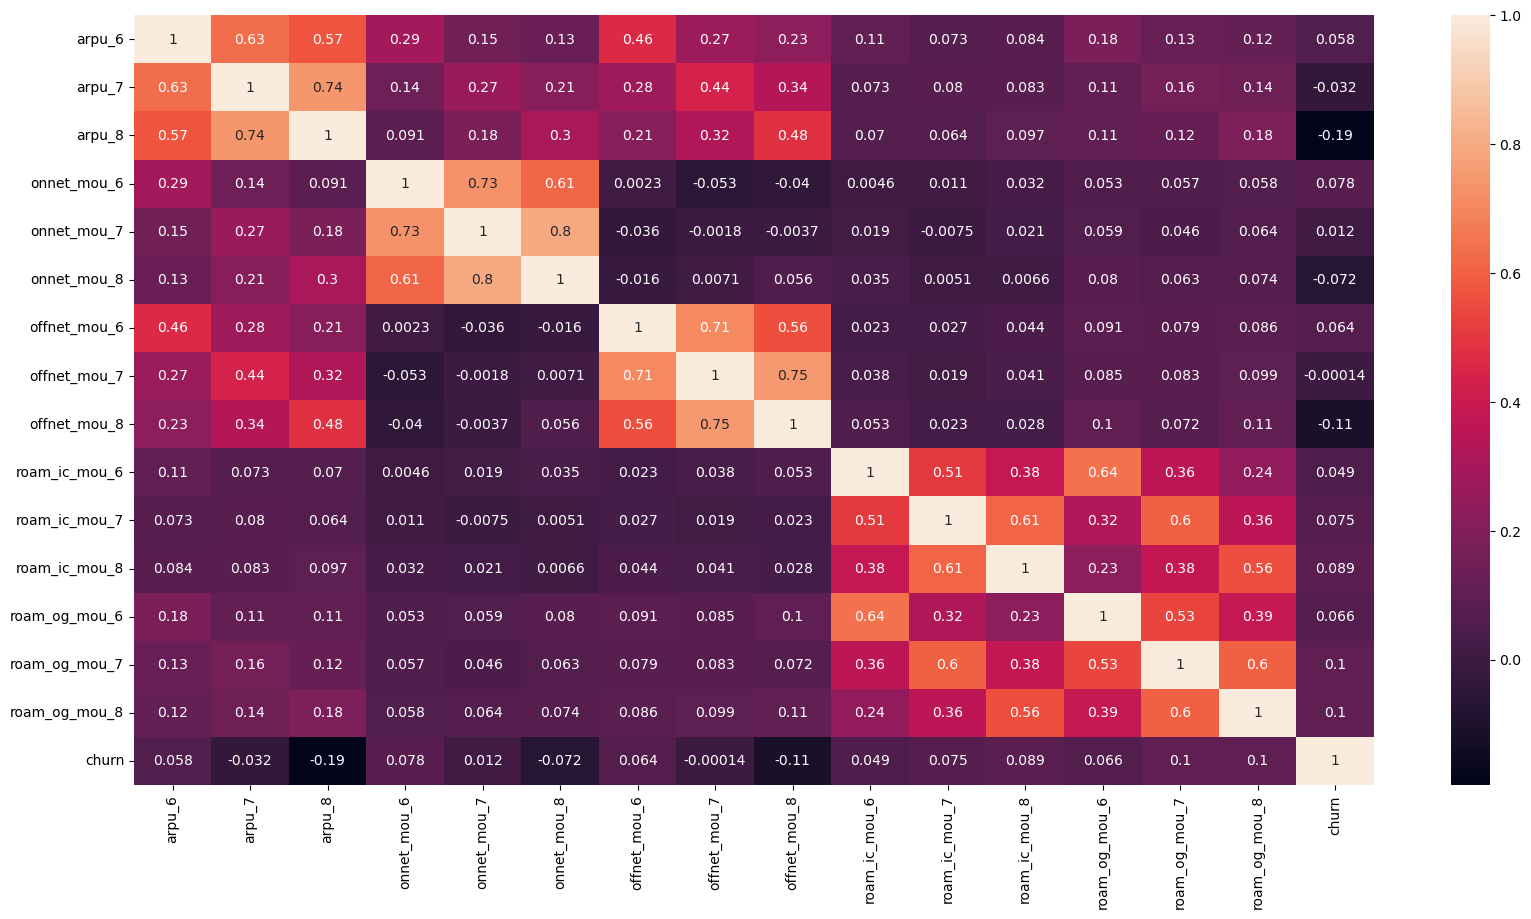

In [59]:
roam_cols = [col for col in data_high_val_cust.columns if 'roam_' in col or'arpu_' in col or'onnet_' in col or 'offnet_' in col]
roam_cols.append('churn')
plt.figure(figsize=(20,10))
sns.heatmap(data_high_val_cust[roam_cols].corr(), annot=True)
plt.show()

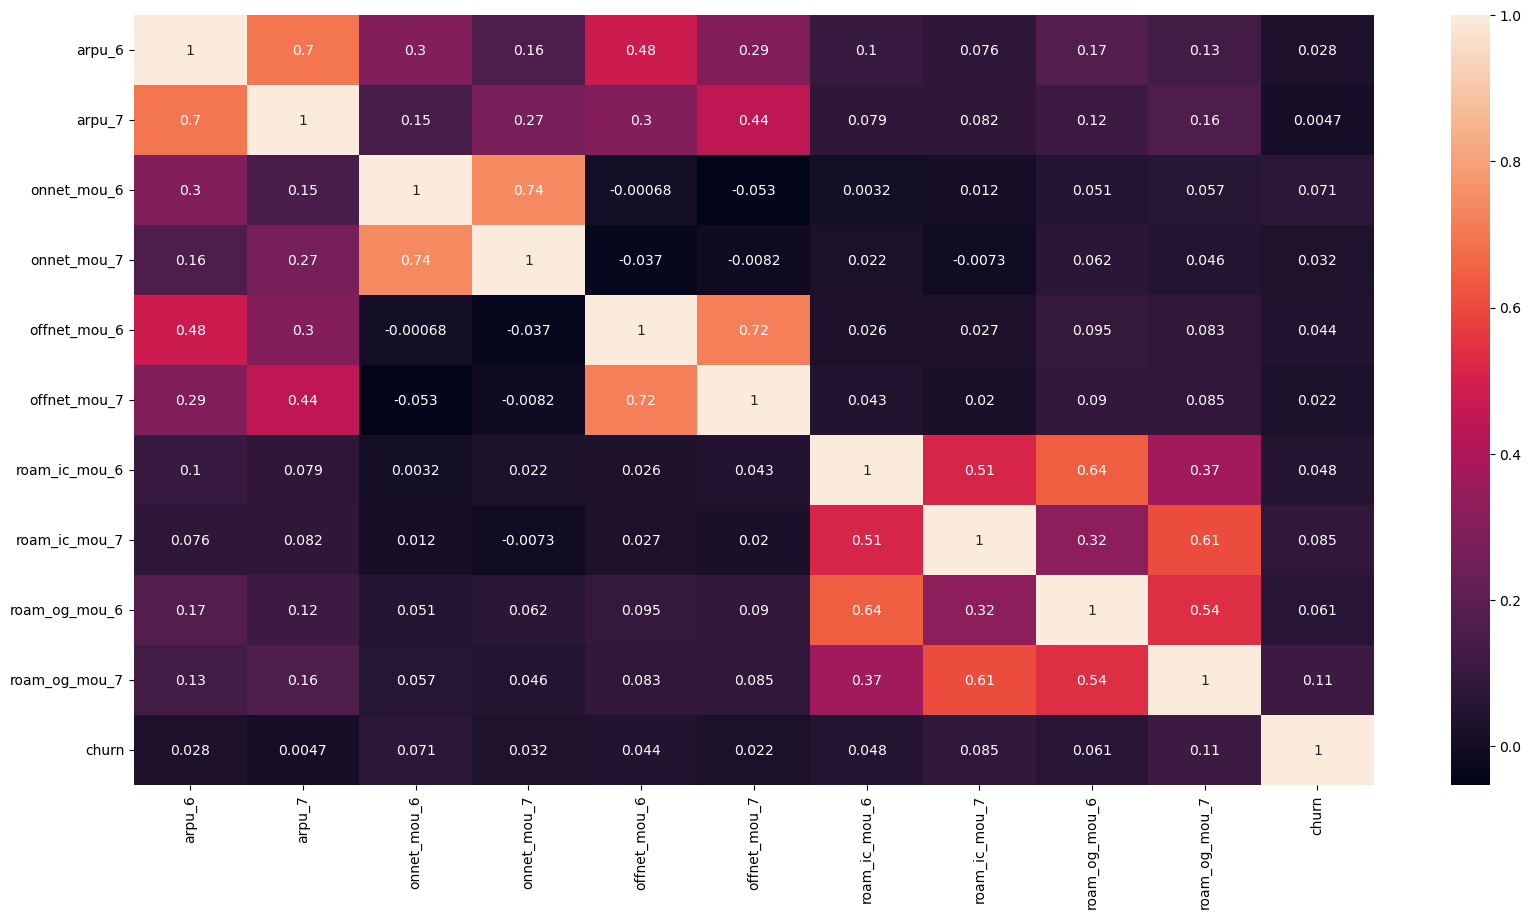

In [88]:
roam_cols = [col for col in data_high_val_cust.columns if ('roam_' in col or'arpu_' in col or'onnet_' in col or 'offnet_' in col)and '_8' not in col]
roam_cols.append('churn')
plt.figure(figsize=(20,10))
sns.heatmap(data_high_val_cust[roam_cols].corr(), annot=True)
plt.show()

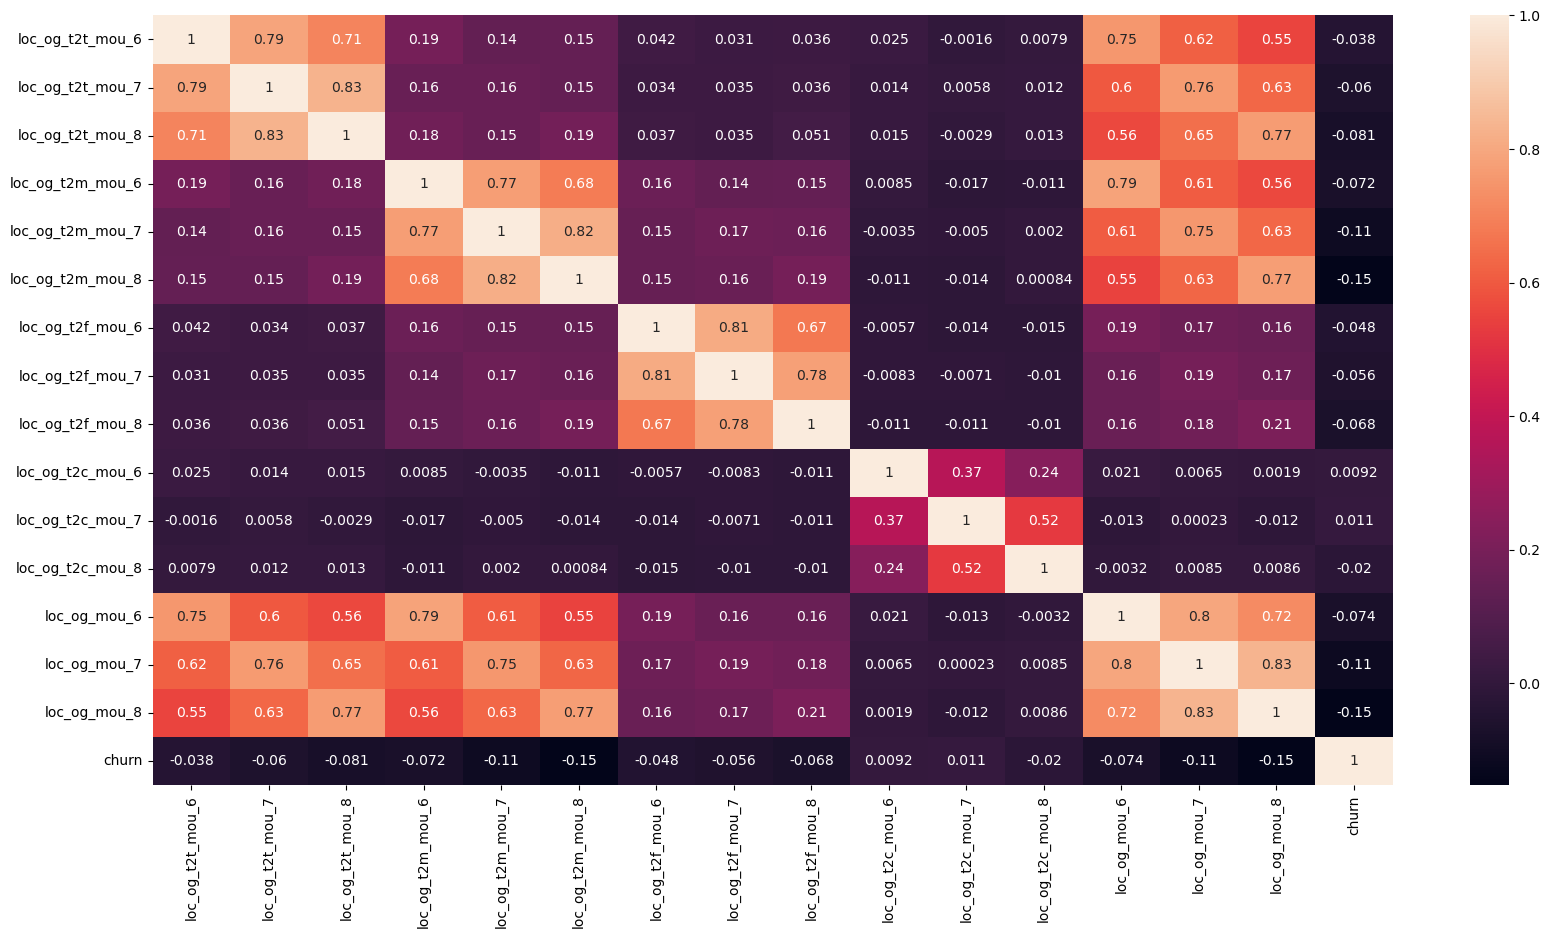

In [51]:
loc_og_cols = [col for col in data_high_val_cust.columns if 'loc_og_' in col]
loc_og_cols.append('churn')
plt.figure(figsize=(20,10))
sns.heatmap(data_high_val_cust[loc_og_cols].corr(), annot=True)
plt.show()

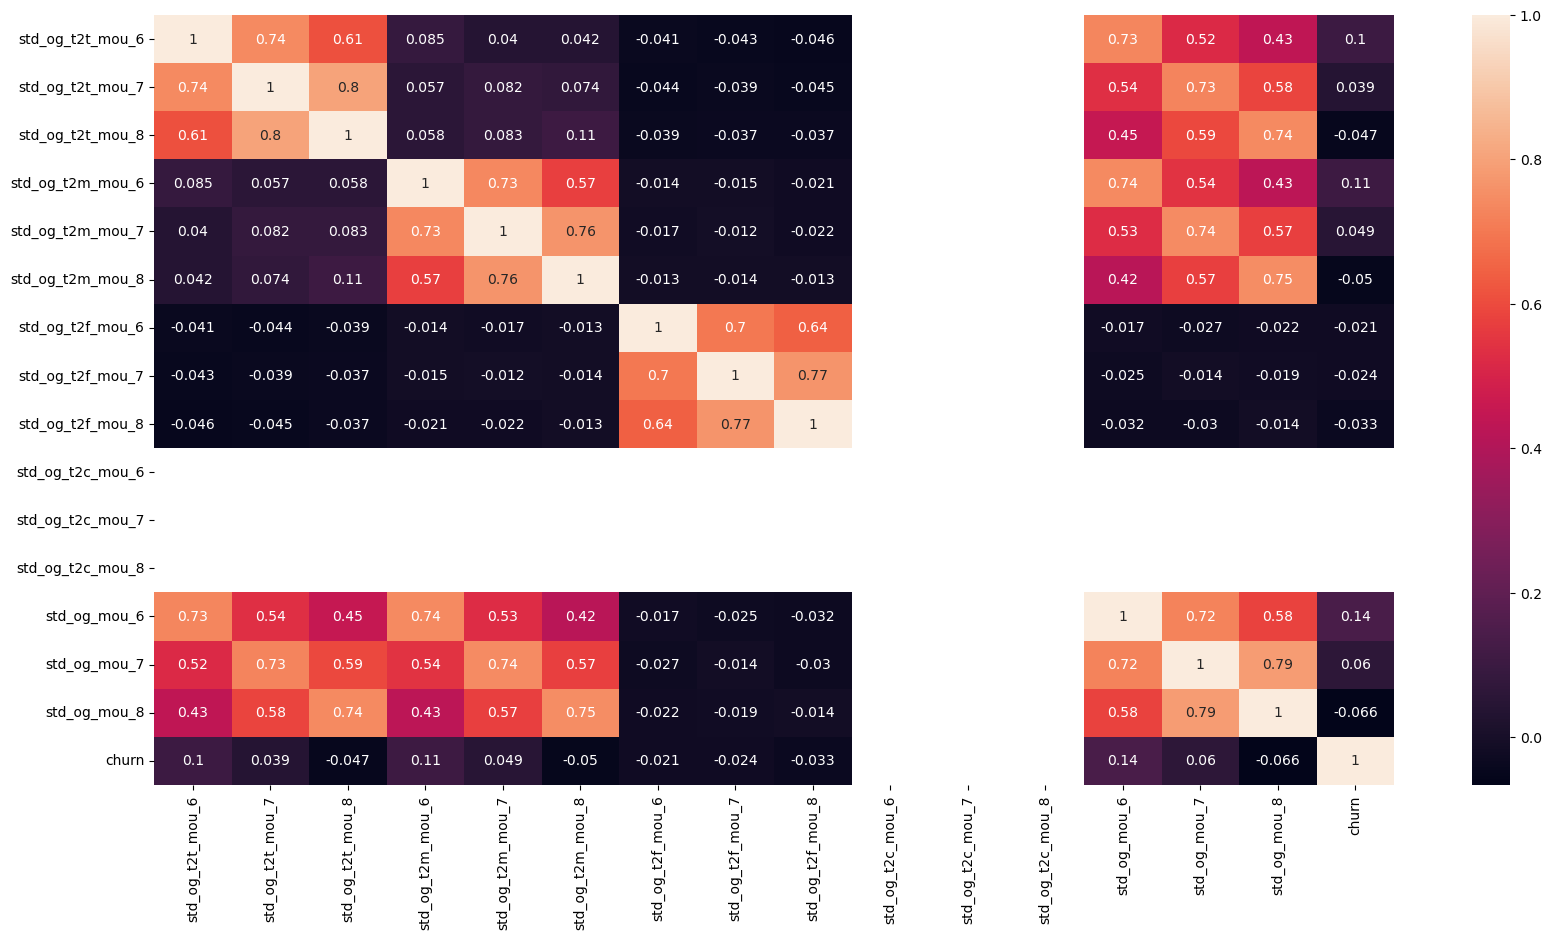

In [52]:
std_og_cols = [col for col in data_high_val_cust.columns if 'std_og_' in col]
std_og_cols.append('churn')
plt.figure(figsize=(20,10))
sns.heatmap(data_high_val_cust[std_og_cols].corr(), annot=True)
plt.show()

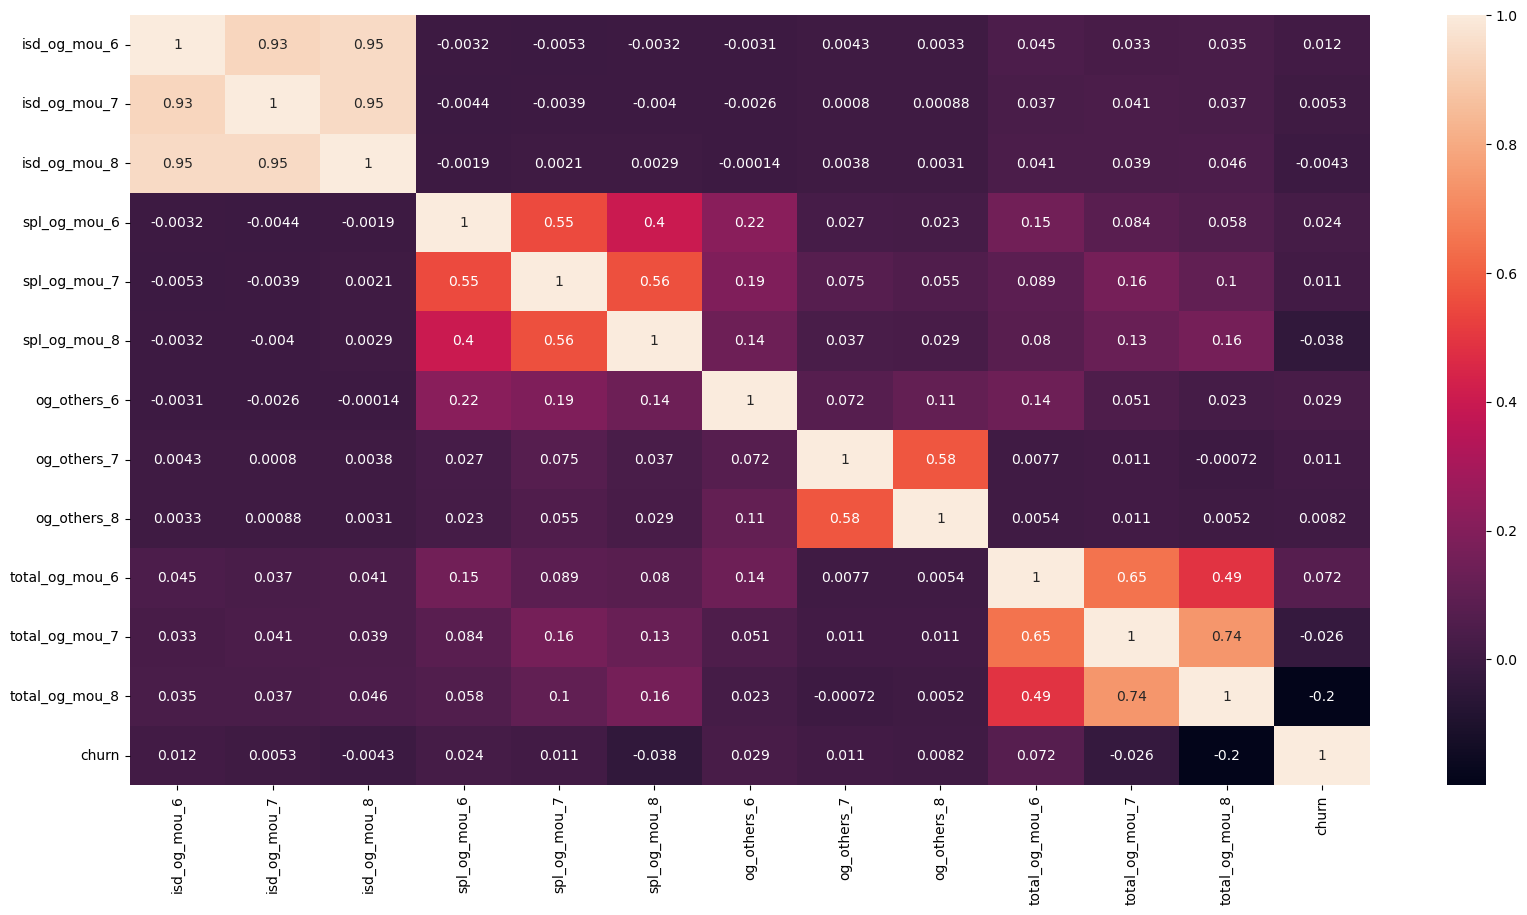

In [53]:
isd_spl_og_cols = [col for col in data_high_val_cust.columns if 'isd_og_' in col or 'spl_og_' in col or 'og_others_' in col or 'total_og_' in col]
isd_spl_og_cols.append('churn')
plt.figure(figsize=(20,10))
sns.heatmap(data_high_val_cust[isd_spl_og_cols].corr(), annot=True)
plt.show()

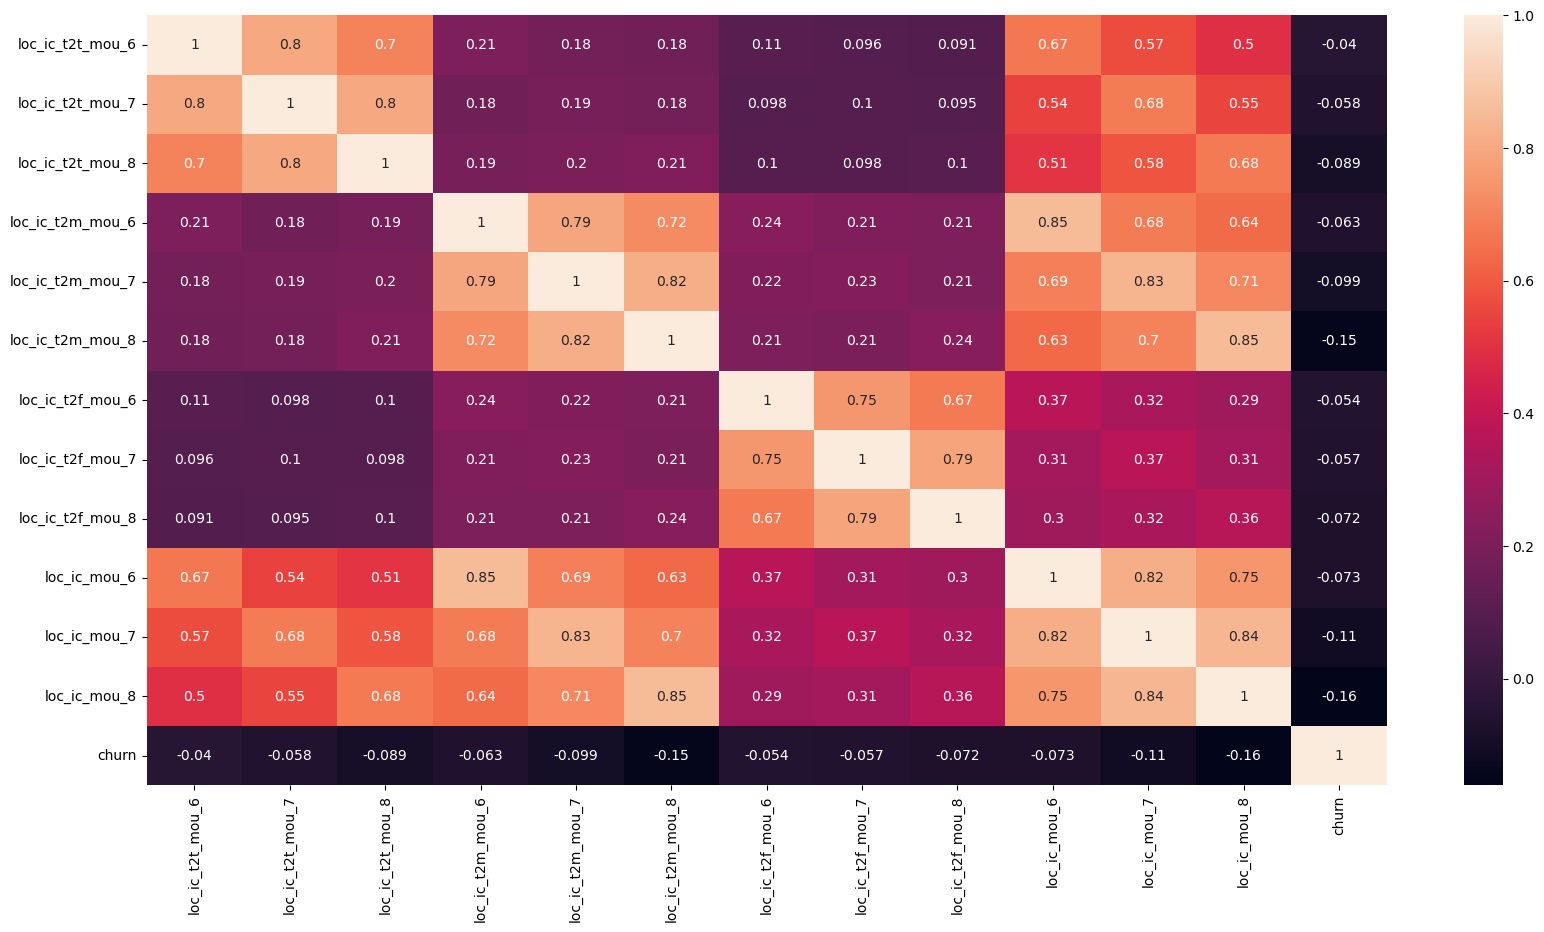

In [54]:
loc_ic_cols = [col for col in data_high_val_cust.columns if 'loc_ic_' in col]
loc_ic_cols.append('churn')
plt.figure(figsize=(20,10))
sns.heatmap(data_high_val_cust[loc_ic_cols].corr(), annot=True)
plt.show()

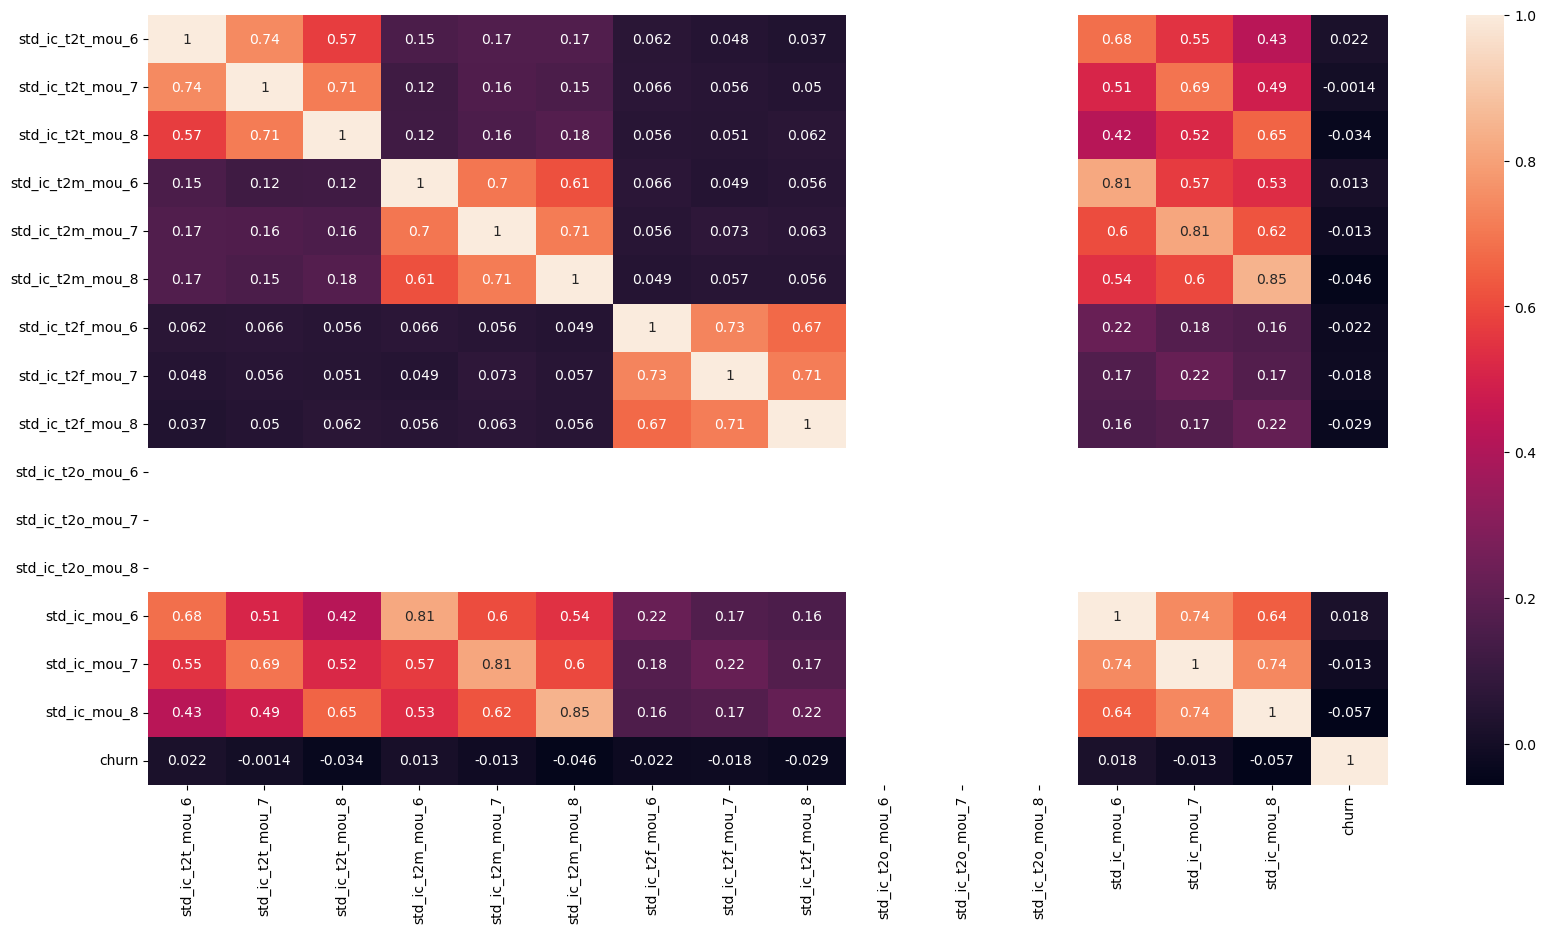

In [55]:
std_ic_cols = [col for col in data_high_val_cust.columns if 'std_ic_' in col]
std_ic_cols.append('churn')
plt.figure(figsize=(20,10))
sns.heatmap(data_high_val_cust[std_ic_cols].corr(), annot=True)
plt.show()

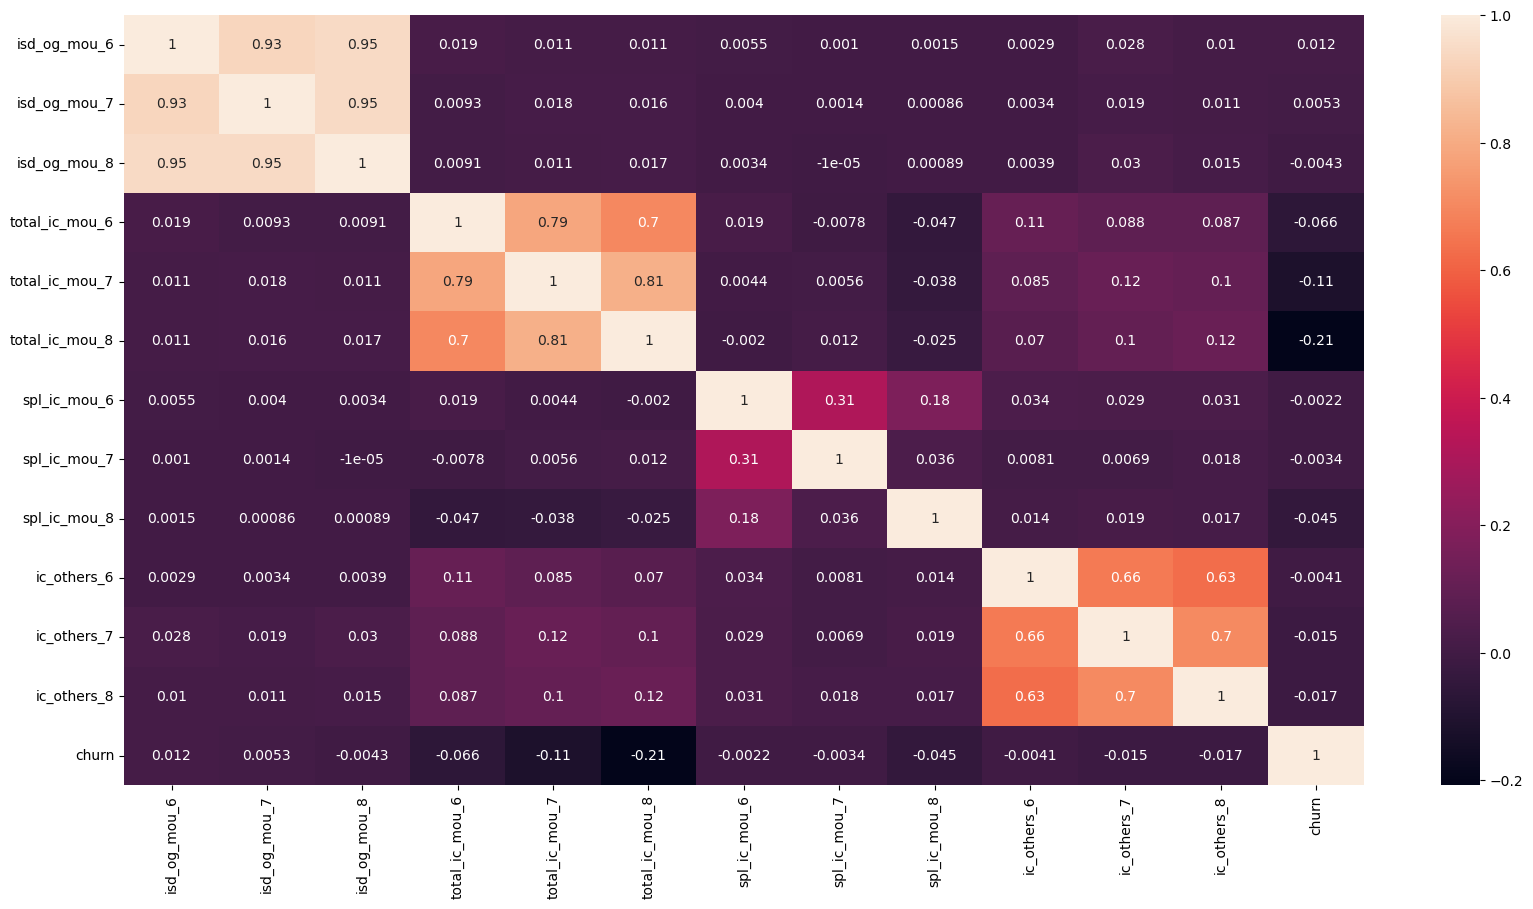

In [56]:
tot_spl_isd_ic_cols = [col for col in data_high_val_cust.columns if 'total_ic_' in col or 'spl_ic_' in col or 'ic_others_' in col or 'isd_og_' in col]
tot_spl_isd_ic_cols.append('churn')
plt.figure(figsize=(20,10))
sns.heatmap(data_high_val_cust[tot_spl_isd_ic_cols].corr(), annot=True)
plt.show()

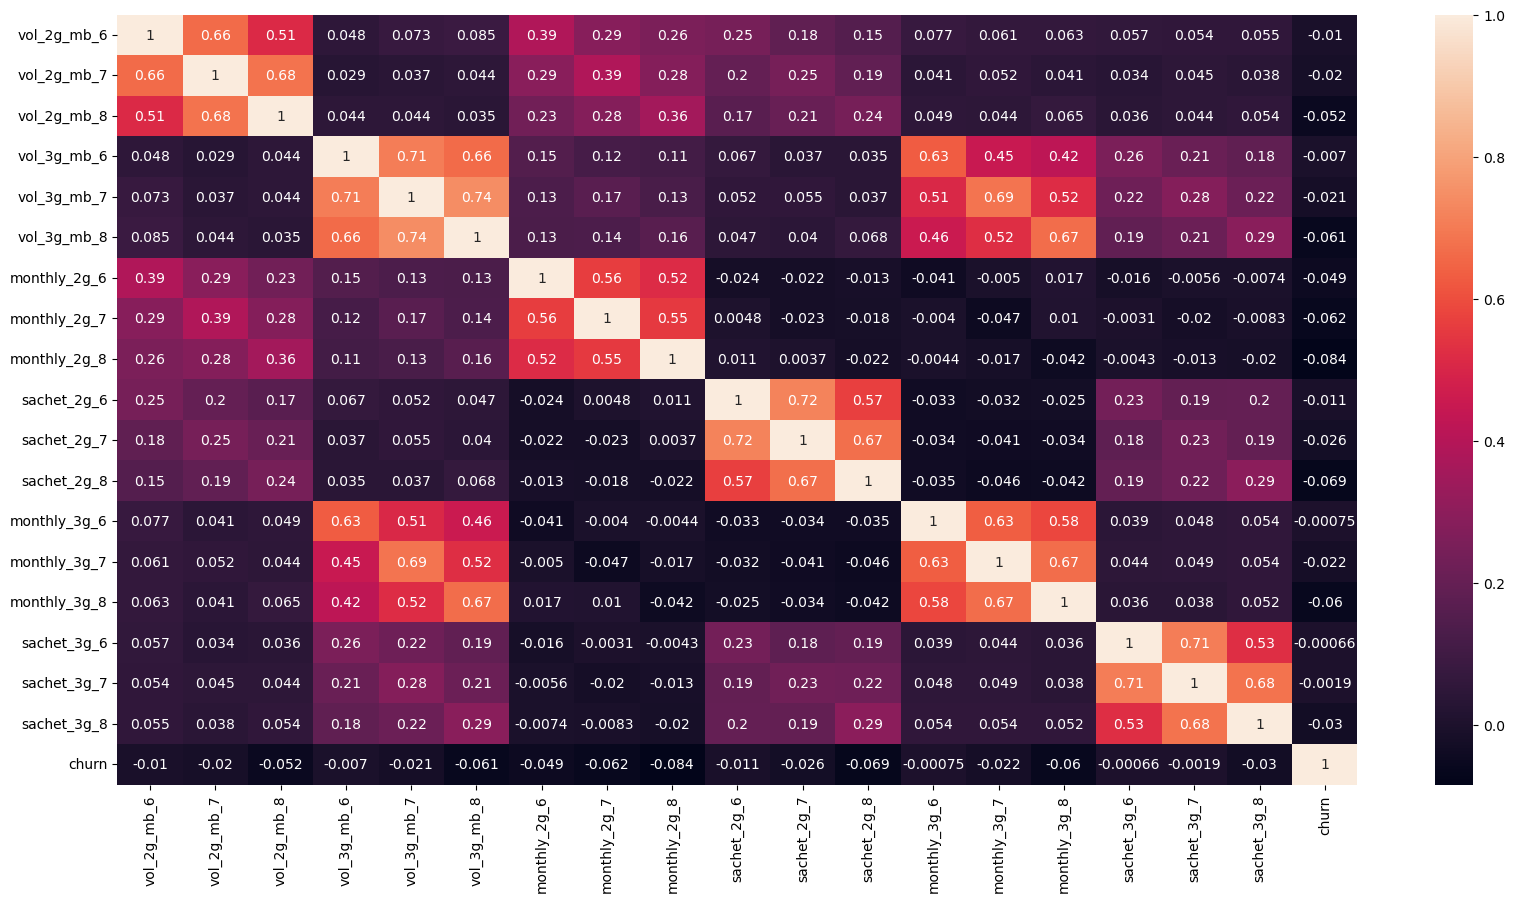

In [60]:
vol_mon_sac_cols = [col for col in data_high_val_cust.columns if 'vol_' in col or 'monthly_' in col or 'sachet_' in col]
vol_mon_sac_cols.append('churn')
plt.figure(figsize=(20,10))
sns.heatmap(data_high_val_cust[vol_mon_sac_cols].corr(), annot=True)
plt.show()

# Dropping NAN values for now, this needs to be worked upon as per outlier analysis

In [69]:
data_high_val_cust = data_high_val_cust.dropna()

In [108]:
X = data_high_val_cust.drop('churn', axis = 1)
y = data_high_val_cust['churn']

In [109]:
X.shape , y.shape

((28487, 134), (28487,))

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [111]:
logreg = LogisticRegression()

# First Model

In [112]:
X_train_sm=sm.add_constant(X_train,has_constant="add")
X_test_sm=sm.add_constant(X_test,has_constant="add")

In [113]:
model1=sm.GLM(np.array(y_train),X_train_sm,family=sm.families.Binomial())
# Binomial --> Binary Classification
result1=model1.fit()
result1.summary()
#Generalised Linear Model

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                19940
Model:                            GLM   Df Residuals:                    19812
Model Family:                Binomial   Df Model:                          127
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Fri, 05 Jul 2024   Deviance:                   2.0843e+05
Time:                        20:56:18   Pearson chi2:                 1.02e+19
No. Iterations:                   100   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -1.306e+15   5.23e+06  -2.49e+08      0.000   -1.31e+15   -1.31e+15
arpu_6               2.547e+10   4344.375   5.86e+06      0.000    2.55e+10    2.55e+10
arpu_7               1.934e+11   4447.922   4.35e+07      0.000    1.93e+11    1.93e+11
arpu_8               7.552e+11   4704.857   1.61e+08      0.000    7.55e+11    7.55e+11
onnet_mou_6          -2.42e+12   7.82e+04  -3.09e+07      0.000   -2.42e+12   -2.42e+12
onnet_mou_7         -1.611e+12   6.23e+04  -2.59e+07      0.000   -1.61e+12   -1.61e+12
onnet_mou_8          7.413e+11    5.3e+04    1.4e+07      0.000    7.41e+11    7.41e+11
offnet_mou_6         -2.68e+12   7.68e+04  -3.49e+07      0.000   -2.68e+12   -2.68e+12
offnet_mou_7        -6.159e+11   5.86e+04  -1.05e+07      0.000   -6.16e+11   -6.16e+11
offnet_mou_8         1.228e+12   5.07e+04   2.42e+07      0.000    1.23e+12    1.23e+12
roam_ic_mou_6       -2.165e+11   9415.250   -2.3e+07      0.000   -2.17e+11   -2.17e+11
roam_ic_mou_7        -1.28e+10   1.07e+04  -1.19e+06      0.000   -1.28e+10   -1.28e+10
roam_ic_mou_8       -6.639e+11   1.01e+04  -6.57e+07      0.000   -6.64e+11   -6.64e+11
roam_og_mou_6        2.575e+12   7.74e+04   3.33e+07      0.000    2.57e+12    2.57e+12
roam_og_mou_7        5.942e+11   6.04e+04   9.83e+06      0.000    5.94e+11    5.94e+11
roam_og_mou_8       -8.863e+11   5.16e+04  -1.72e+07      0.000   -8.86e+11   -8.86e+11
loc_og_t2t_mou_6    -5.305e+15   7.78e+07  -6.81e+07      0.000    -5.3e+15    -5.3e+15
loc_og_t2t_mou_7    -2.381e+15   7.94e+07     -3e+07      0.000   -2.38e+15   -2.38e+15
loc_og_t2t_mou_8    -5.658e+15   8.09e+07  -6.99e+07      0.000   -5.66e+15   -5.66e+15
loc_og_t2m_mou_6    -5.304e+15   7.78e+07  -6.81e+07      0.000    -5.3e+15    -5.3e+15
loc_og_t2m_mou_7    -2.383e+15   7.94e+07     -3e+07      0.000   -2.38e+15   -2.38e+15
loc_og_t2m_mou_8    -5.658e+15   8.09e+07  -6.99e+07      0.000   -5.66e+15   -5.66e+15
loc_og_t2f_mou_6    -5.303e+15   7.79e+07  -6.81e+07      0.000    -5.3e+15    -5.3e+15
loc_og_t2f_mou_7    -2.379e+15   7.94e+07  -2.99e+07      0.000   -2.38e+15   -2.38e+15
loc_og_t2f_mou_8    -5.663e+15   8.09e+07     -7e+07      0.000   -5.66e+15   -5.66e+15
loc_og_t2c_mou_6    -5.802e+12   8.92e+04   -6.5e+07      0.000    -5.8e+12    -5.8e+12
loc_og_t2c_mou_7    -3.006e+12   7.49e+04  -4.02e+07      0.000   -3.01e+12   -3.01e+12
loc_og_t2c_mou_8     1.969e+12   7.96e+04   2.47e+07      0.000    1.97e+12    1.97e+12
loc_og_mou_6         2.922e+15   9.34e+07   3.13e+07      0.000    2.92e+15    2.92e+15
loc_og_mou_7         1.331e+16   9.64e+07   1.38e+08      0.000    1.33e+16    1.33e+16
loc_og_mou_8         8.279e+15   1.04e+08   7.95e+07      0.000    8.28e+15    8.28e+15
std_og_t2t_mou_6    -5.182e+15   9.72e+07  -5.33e+07      0.000   -5.18e+15   -5.18e+15
std

### As we see from above results, the log likelihood is nan, which means the model fit is poor. We need to handle outliers, multicollinearity and scaling of features


### Getting parameters from RFE 

In [89]:
rfe = RFE(estimator=logreg, n_features_to_select=100)
rfe.fit(X_train, y_train)

RFE(estimator=LogisticRegression(), n_features_to_select=100)

In [90]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('arpu_6', True, 1),
 ('arpu_7', True, 1),
 ('arpu_8', False, 22),
 ('onnet_mou_6', True, 1),
 ('onnet_mou_7', False, 21),
 ('onnet_mou_8', True, 1),
 ('offnet_mou_6', True, 1),
 ('offnet_mou_7', True, 1),
 ('offnet_mou_8', True, 1),
 ('roam_ic_mou_6', False, 26),
 ('roam_ic_mou_7', True, 1),
 ('roam_ic_mou_8', False, 20),
 ('roam_og_mou_6', True, 1),
 ('roam_og_mou_7', True, 1),
 ('roam_og_mou_8', True, 1),
 ('loc_og_t2t_mou_6', True, 1),
 ('loc_og_t2t_mou_7', False, 10),
 ('loc_og_t2t_mou_8', True, 1),
 ('loc_og_t2m_mou_6', False, 4),
 ('loc_og_t2m_mou_7', True, 1),
 ('loc_og_t2m_mou_8', True, 1),
 ('loc_og_t2f_mou_6', True, 1),
 ('loc_og_t2f_mou_7', False, 24),
 ('loc_og_t2f_mou_8', True, 1),
 ('loc_og_t2c_mou_6', True, 1),
 ('loc_og_t2c_mou_7', True, 1),
 ('loc_og_t2c_mou_8', False, 18),
 ('loc_og_mou_6', True, 1),
 ('loc_og_mou_7', True, 1),
 ('loc_og_mou_8', True, 1),
 ('std_og_t2t_mou_6', False, 16),
 ('std_og_t2t_mou_7', True, 1),
 ('std_og_t2t_mou_8', False, 2),
 ('std_og_t2m

In [91]:
X_train.columns[rfe.support_]

Index(['arpu_6', 'arpu_7', 'onnet_mou_6', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_7', 'roam_og_mou_6',
       'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6',
       'loc_og_t2t_mou_8', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6',
       'loc_og_t2c_mou_7', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8',
       'std_og_t2t_mou_7', 'std_og_t2m_mou_6', 'std_og_t2m_mou_8',
       'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8',
       'std_og_mou_6', 'std_og_mou_7', 'isd_og_mou_7', 'isd_og_mou_8',
       'spl_og_mou_6', 'spl_og_mou_8', 'og_others_6', 'og_others_7',
       'og_others_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8',
       'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6',
       'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_6',
       'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8', 'loc_ic_mou_6', 'loc_ic_mou_7',
       'loc_ic_mou_8'

In [92]:
col_rfe_support = X_train.columns[rfe.support_]

In [93]:
logm1 = sm.GLM(y_train,(sm.add_constant(X_train[col_rfe_support])), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                19940
Model:                            GLM   Df Residuals:                    19839
Model Family:                Binomial   Df Model:                          100
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3640.6
Date:                Fri, 05 Jul 2024   Deviance:                       7281.1
Time:                        19:48:46   Pearson chi2:                 4.21e+05
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1559
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.8791      0.342      8.414      0.000       2.208       3.550
arpu_6                 0.0001      0.000      0.416      0.678      -0.001       0.001
arpu_7              5.277e-06      0.000      0.016      0.988      -0.001       0.001
onnet_mou_6           -0.0068      0.006     -1.139      0.255      -0.019       0.005
onnet_mou_8            0.0003      0.003      0.126      0.899      -0.005       0.006
offnet_mou_6          -0.0075      0.006     -1.253      0.210      -0.019       0.004
offnet_mou_7           0.0006      0.001      0.703      0.482      -0.001       0.002
offnet_mou_8          -0.0009      0.003     -0.332      0.740      -0.006       0.004
roam_ic_mou_7          0.0011      0.000      3.192      0.001       0.000       0.002
roam_og_mou_6          0.0074      0.006      1.230      0.219      -0.004       0.019
roam_og_mou_7          0.0014      0.001      2.073      0.038    7.66e-05       0.003
roam_og_mou_8          0.0005      0.003      0.203      0.840      -0.005       0.006
loc_og_t2t_mou_6      -0.0002      0.001     -0.176      0.861      -0.002       0.002
loc_og_t2t_mou_8      34.7434      6.069      5.725      0.000      22.849      46.638
loc_og_t2m_mou_7      -0.0008      0.001     -0.767      0.443      -0.003       0.001
loc_og_t2m_mou_8      34.7446      6.069      5.725      0.000      22.850      46.639
loc_og_t2f_mou_6      -0.0002      0.003     -0.088      0.930      -0.005       0.005
loc_og_t2f_mou_8      34.7426      6.069      5.724      0.000      22.847      46.638
loc_og_t2c_mou_6    8.964e-05      0.005      0.019      0.985      -0.009       0.009
loc_og_t2c_mou_7      -0.0005      0.004     -0.145      0.885      -0.008       0.007
loc_og_mou_6           0.0030      0.003      1.031      0.302      -0.003       0.009
loc_og_mou_7          -0.0014      0.002     -0.635      0.525      -0.006       0.003
loc_og_mou_8         -34.7443      6.069     -5.725      0.000     -46.639     -22.850
std_og_t2t_mou_7       0.0002      0.001      0.225      0.822      -0.002       0.002
std_og_t2m_mou_6       0.0004      0.001      0.569      0.569      -0.001       0.002
std_og_t2m_mou_8       0.0010      0.001      1.371      0.170      -0.000       0.002
std_og_t2f_mou_6       0.0029      0.003      0.846      0.397      -0.004       0.010
std_og_t2f_mou_7      -0.0095      0.006     -1.639      0.101      -0.021       0.002
std_og_t2f_mou_8      -0.0042      0.009     -0.477      0.634      -0.022       0.013
std_og_mou_6           0.0029      0.003      0.951      0.341      -0.003       0.009
std_og_mou_7          -0.0019      0.002     -0.916      0.360      -0.006       0.002
isd_og_mou_7           0.0060      0.004      1.651      0.099      -0.001       0.013
isd_og_mou_8          -0.0017      0.0

## As its hard to guess on the number of features to be used for RFE model, implementing RFECV to get a better understanding on the number of features which can give a maximum performance on logistic regression model.

In [94]:
rfecv = RFECV(estimator = logreg, cv = 4)
rfecv.fit(X_train, y_train)

RFECV(cv=4, estimator=LogisticRegression())

In [96]:
rfecv.n_features_

65

In [100]:
rfecv.support_

array([False, False, False, False, False,  True,  True,  True,  True,
       False,  True, False,  True,  True,  True, False, False, False,
       False,  True, False, False, False,  True, False,  True, False,
        True,  True,  True, False,  True, False,  True, False,  True,
       False,  True,  True, False, False, False,  True,  True, False,
       False,  True, False, False, False,  True,  True,  True,  True,
       False,  True,  True,  True, False,  True,  True, False,  True,
        True, False,  True,  True,  True,  True, False, False,  True,
       False,  True,  True, False,  True,  True, False, False, False,
        True,  True,  True, False, False,  True, False, False, False,
        True, False,  True,  True,  True, False,  True,  True,  True,
        True, False,  True, False, False,  True, False, False,  True,
       False,  True,  True, False, False, False, False, False, False,
       False,  True,  True, False, False, False, False, False, False,
       False,  True,

In [101]:
col_rfecv_support = X_train.columns[rfecv.support_]

### Fitting the model again with rfecv identified features

In [104]:
logm2 = sm.GLM(y_train,(sm.add_constant(X_train[col_rfecv_support])), family = sm.families.Binomial())
logm2.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                19940
Model:                            GLM   Df Residuals:                    19874
Model Family:                Binomial   Df Model:                           65
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3764.4
Date:                Fri, 05 Jul 2024   Deviance:                       7528.9
Time:                        20:02:46   Pearson chi2:                 2.53e+05
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1454
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.5483      0.327      7.803      0.000       1.908       3.188
onnet_mou_8           -0.0003      0.003     -0.127      0.899      -0.006       0.005
offnet_mou_6          -0.0005      0.000     -1.484      0.138      -0.001       0.000
offnet_mou_7        9.724e-05      0.001      0.130      0.896      -0.001       0.002
offnet_mou_8          -0.0014      0.003     -0.496      0.620      -0.007       0.004
roam_ic_mou_7          0.0012      0.000      3.412      0.001       0.001       0.002
roam_og_mou_6          0.0005      0.000      1.370      0.171      -0.000       0.001
roam_og_mou_7          0.0015      0.001      2.616      0.009       0.000       0.003
roam_og_mou_8          0.0015      0.003      0.567      0.571      -0.004       0.007
loc_og_t2m_mou_7   -5.791e-05      0.001     -0.078      0.938      -0.002       0.001
loc_og_t2f_mou_8      -0.0059      0.004     -1.329      0.184      -0.015       0.003
loc_og_t2c_mou_7      -0.0011      0.003     -0.353      0.724      -0.007       0.005
loc_og_mou_6           0.0004      0.000      1.354      0.176      -0.000       0.001
loc_og_mou_7          -0.0031      0.002     -1.614      0.107      -0.007       0.001
loc_og_mou_8          -0.0006      0.000     -1.324      0.185      -0.002       0.000
std_og_t2t_mou_7      -0.0003      0.001     -0.340      0.734      -0.002       0.001
std_og_t2m_mou_6       0.0003      0.000      0.744      0.457      -0.000       0.001
std_og_t2m_mou_8       0.0008      0.001      1.390      0.164      -0.000       0.002
std_og_t2f_mou_7      -0.0089      0.006     -1.564      0.118      -0.020       0.002
std_og_t2f_mou_8      -0.0055      0.009     -0.613      0.540      -0.023       0.012
std_og_mou_6           0.0004      0.000      3.674      0.000       0.000       0.001
std_og_mou_7          -0.0029      0.002     -1.603      0.109      -0.006       0.001
isd_og_mou_7           0.0017      0.002      0.706      0.480      -0.003       0.006
spl_og_mou_8          -0.0021      0.003     -0.845      0.398      -0.007       0.003
og_others_6           -0.0209      0.014     -1.460      0.144      -0.049       0.007
og_others_7           -0.0043      0.013     -0.316      0.752      -0.031       0.022
og_others_8            0.0150      0.014      1.042      0.298      -0.013       0.043
total_og_mou_7         0.0033      0.002      1.761      0.078      -0.000       0.007
total_og_mou_8        -0.0004      0.003     -0.154      0.877      -0.006       0.005
loc_ic_t2t_mou_6      11.9913      5.154      2.327      0.020       1.890      22.092
loc_ic_t2t_mou_8      48.5913      5.529      8.788      0.000      37.754      59.429
loc_ic_t2m_mou_6      11.9917      5.154      2.327      0.020       1.891      22.093
loc_ic_t2m_mou_8      48.5920      5.5

In [107]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col_rfecv_support].columns
vif['VIF'] = [variance_inflation_factor(X_train[col_rfecv_support].values, i) for i in range(X_train[col_rfecv_support].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
34,loc_ic_mou_6,4.319447e+09
36,loc_ic_mou_8,4.209365e+09
30,loc_ic_t2m_mou_6,2.085367e+09
31,loc_ic_t2m_mou_8,2.052222e+09
44,std_ic_mou_8,8.375049e+08
...,...,...
48,ic_others_6,1.550000e+00
10,loc_og_t2c_mou_7,1.540000e+00
61,aug_vbc_3g,1.330000e+00
23,og_others_6,1.320000e+00
